#**Swin-UperNet Model Training Notebook**

##Step 1: Importing Libraries and Mounting Files from Google Drive

In [ ]:
# Install required packages (run this cell only once)
!pip install torch torchvision --quiet
!pip install timm==0.9.2 --quiet
!pip install segmentation-models-pytorch --quiet
!pip install torchinfo --quiet
!pip install torchmetrics==0.11.4 --quiet

In [2]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import timm
from timm import create_model
from torch.utils.data import Dataset, DataLoader
import torchinfo
from torchinfo import summary
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import torchmetrics
import segmentation_models_pytorch as smp
from google.colab import drive
from PIL import Image

In [3]:
print(torchmetrics.__version__)
print(torch.__version__)
print(timm.__version__)
print(smp.__version__)
print(torchinfo.__version__)

0.11.4
2.6.0+cu124
0.9.2
0.4.0
1.8.0


In [4]:
# Mount Google Drive if running on Colab and set BASE_DIR for your processed dataset.
IN_COLAB = "google.colab" in str(get_ipython())
if IN_COLAB:
    print("Running in Google Colab: Mounting Drive...")
    drive.mount('/content/drive')
    # Update the BASE_DIR to point to your folder with processed .npy files
    BASE_DIR = "/content/drive/MyDrive/swinunet-medical-segmentation/dataset/processed_dataset"
else:
    BASE_DIR = "/path/to/local/dataset/processed_dataset"

Running in Google Colab: Mounting Drive...
Mounted at /content/drive


## Step 2: Verify GPU and Environment

In [5]:
print("GPU Available:", torch.cuda.is_available()) # checks if a GPU is accessible.

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Running on device:", device)

GPU Available: True
GPU Name: NVIDIA A100-SXM4-40GB
Running on device: cuda


## Step 3: Define a PyTorch Dataset for Our Preprocessed .npy Files

Now we’ll create a custom Dataset class that reads our images and masks from the .npy files. This allows us to easily use DataLoader for batching and shuffling. (This is a common practice for PyTorch).

In [6]:
class ISICDataset(Dataset):
    def __init__(self, images_path, masks_path, transform=None):
        """
        images_path: Path to the .npy file containing image data (shape: (N, H, W, C))
        masks_path : Path to the .npy file containing mask data  (shape: (N, H, W))
        transform  : Optional transform (e.g., resizing, normalization)
        """
        self.images = np.load(images_path)  # shape: (N, H, W, C)
        self.masks  = np.load(masks_path)   # shape: (N, H, W)
        self.transform = transform  # Store transform for later use

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """
        Retrieve the sample (image, mask) at index 'idx' and apply transforms.
        """
        image = self.images[idx]  # shape: (H, W, C)
        mask  = self.masks[idx]   # shape: (H, W)

        # Convert to PIL image for transforms
        image = T.ToPILImage()(image)
        mask  = torch.tensor(mask, dtype=torch.long)  # Keep mask as tensor

        # Apply transformation (resize only affects image)
        if self.transform:
            image = self.transform(image)

        return image, mask  # Image: [3, 224, 224], Mask: [256, 256]

## Step 4: Create a DataLoader for Training & Validation

Now that we have our ISICDataset class defined, let’s set up the DataLoader. This allows us to:

1. Batch our images and masks (e.g., batches of size 64).
2. Shuffle the data for training.
3. Potentially use multiple workers to speed up data loading.

In [7]:
# Define file paths for training, validation, and test sets
train_images_path = os.path.join(BASE_DIR, "train_images.npy")
train_masks_path  = os.path.join(BASE_DIR, "train_masks.npy")
val_images_path   = os.path.join(BASE_DIR, "val_images.npy")
val_masks_path    = os.path.join(BASE_DIR, "val_masks.npy")
test_images_path  = os.path.join(BASE_DIR, "test_images.npy")
test_masks_path   = os.path.join(BASE_DIR, "test_masks.npy")

# Define transformation to resize images to 224x224
transform = T.Compose([
    T.Resize((224, 224)),  # Resize to match Swin-Tiny input
    T.ToTensor()           # Convert to PyTorch tensor (C, H, W)
])

# Create dataset instances
train_dataset = ISICDataset(train_images_path, train_masks_path, transform=transform)
val_dataset   = ISICDataset(val_images_path, val_masks_path, transform=transform)
test_dataset  = ISICDataset(test_images_path, test_masks_path, transform=transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=8, pin_memory=True)

# Quick test: Display batch shapes
train_batch = next(iter(train_loader))
images, masks = train_batch
print("Train Images batch shape:", images.shape)  # Expected: [B, 3, H, W]
print("Train Masks batch shape:", masks.shape)    # Expected: [B, H, W]

# Test that test dataset is properly loaded
test_batch = next(iter(test_loader))
test_images, test_masks = test_batch
print("Test Images batch shape:", test_images.shape)
print("Test Masks batch shape:", test_masks.shape)

Train Images batch shape: torch.Size([32, 3, 224, 224])
Train Masks batch shape: torch.Size([32, 256, 256])
Test Images batch shape: torch.Size([32, 3, 224, 224])
Test Masks batch shape: torch.Size([32, 256, 256])


## Step 5: Define the Baseline Swin-UperNet Model

In [16]:
# -------------------------------
# Define Pyramid Pooling Module (with GroupNorm)
# -------------------------------
class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, pool_sizes=[1, 2, 3, 6]):
        super().__init__()
        # Use GroupNorm instead of BatchNorm to handle small spatial sizes.
        self.pool_layers = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(pool_size),
                nn.Conv2d(in_channels, in_channels // 4, kernel_size=1, bias=False),
                nn.GroupNorm(num_groups=8, num_channels=in_channels // 4),
                nn.ReLU(inplace=True)
            ) for pool_size in pool_sizes
        ])
        total_channels = in_channels + len(pool_sizes) * (in_channels // 4)
        self.conv = nn.Conv2d(total_channels, in_channels, kernel_size=1, bias=False)

    def forward(self, x):
        pooled_features = [x]
        for layer in self.pool_layers:
            pooled = layer(x)
            pooled = F.interpolate(pooled, size=x.shape[2:], mode='bilinear', align_corners=False)
            pooled_features.append(pooled)
        x = torch.cat(pooled_features, dim=1)
        x = self.conv(x)
        return x

# -------------------------------
# Define UPerNet-Style Decoder
# -------------------------------
class UPerNetDecoder(nn.Module):
    def __init__(self, encoder_channels=[96, 192, 384, 768], num_classes=1):
        """
        For a 256x256 input, encoder feature maps are expected to be:
        f0: [B, 96, 64, 64], f1: [B, 192, 32, 32],
        f2: [B, 384, 16, 16], f3: [B, 768, 8, 8].
        """
        super().__init__()
        self.ppm = PyramidPoolingModule(encoder_channels[-1])

        self.lateral_conv2 = nn.Conv2d(encoder_channels[2], encoder_channels[-1], kernel_size=1)
        self.conv3 = nn.Sequential(
            nn.Conv2d(encoder_channels[-1], encoder_channels[2], kernel_size=1),
            nn.Dropout2d(p=0.2)  # Dropout added here
        )

        self.lateral_conv1 = nn.Conv2d(encoder_channels[1], 384, kernel_size=1)
        self.conv2 = nn.Sequential(
            nn.Conv2d(384, encoder_channels[1], kernel_size=1),
            nn.Dropout2d(p=0.2)  # Dropout added here
        )

        self.lateral_conv0 = nn.Conv2d(encoder_channels[0], encoder_channels[1], kernel_size=1)
        self.conv1 = nn.Sequential(
            nn.Conv2d(encoder_channels[1], encoder_channels[0], kernel_size=1),
            nn.Dropout2d(p=0.2)  # Dropout added here
        )

        self.segmentation_head = nn.Conv2d(encoder_channels[0], num_classes, kernel_size=1)


    def forward(self, features):
        f0, f1, f2, f3 = features

        x3 = self.ppm(f3)  # [B, 768, 8, 8]
        x3_up = F.interpolate(x3, size=f2.shape[2:], mode="bilinear", align_corners=False)  # 16x16
        f2_lat = self.lateral_conv2(f2)  # [B, 768, 16, 16]
        fuse2 = x3_up + f2_lat
        fuse2 = self.conv3(fuse2)  # [B, 384, 16, 16]

        fuse2_up = F.interpolate(fuse2, size=f1.shape[2:], mode="bilinear", align_corners=False)  # 32x32
        f1_lat = self.lateral_conv1(f1)  # [B, 384, 32, 32]
        fuse1 = fuse2_up + f1_lat
        fuse1 = self.conv2(fuse1)  # [B, 192, 32, 32]

        fuse1_up = F.interpolate(fuse1, size=f0.shape[2:], mode="bilinear", align_corners=False)  # 64x64
        f0_lat = self.lateral_conv0(f0)  # [B, 192, 64, 64]
        fuse0 = fuse1_up + f0_lat
        fuse0 = self.conv1(fuse0)  # [B, 96, 64, 64]

        x_out = F.interpolate(fuse0, scale_factor=4, mode="bilinear", align_corners=False)
        output = self.segmentation_head(x_out)  # [B, num_classes, 256, 256]
        return output

# -------------------------------
# Define the Combined Model (Using Swin-Tiny with ImageNet-22K Weights)
# -------------------------------
class SwinUPerNet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.encoder = timm.create_model(
            "swin_tiny_patch4_window7_224.ms_in22k",
            pretrained=True,
            features_only=True
        )

        encoder_channels = self.encoder.feature_info.channels()
        self.decoder = UPerNetDecoder(encoder_channels, num_classes)

    def forward(self, x):
        # Get feature maps from Swin Transformer
        features = self.encoder(x)

        # Convert NHWC to NCHW
        features = [f.permute(0, 3, 1, 2) for f in features]

        # Decode feature maps back to 256x256 masks
        output = self.decoder(features)

        # Resize output to match input size (256x256)
        output = F.interpolate(output, size=(256, 256), mode="bilinear", align_corners=False)

        return output

# -------------------------------
# Instantiate and Test the Model
# -------------------------------
if __name__ == "__main__":
    model = SwinUPerNet(num_classes=1).to(device)
    print("SwinUPerNet Model Summary:")

    # Update input size to 256x256
    print(summary(model, input_size=(1, 3, 224, 224)))

    # Update dummy input to 256x256
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    output = model(dummy_input)
    print("Output shape:", output.shape)

SwinUPerNet Model Summary:
Layer (type:depth-idx)                             Output Shape              Param #
SwinUPerNet                                        [1, 1, 256, 256]          --
├─FeatureListNet: 1-1                              [1, 56, 56, 96]           --
│    └─PatchEmbed: 2-1                             [1, 56, 56, 96]           --
│    │    └─Conv2d: 3-1                            [1, 96, 56, 56]           4,704
│    │    └─LayerNorm: 3-2                         [1, 56, 56, 96]           192
│    └─SwinTransformerStage: 2-2                   [1, 56, 56, 96]           --
│    │    └─Identity: 3-3                          [1, 56, 56, 96]           --
│    │    └─Sequential: 3-4                        [1, 56, 56, 96]           224,694
│    └─SwinTransformerStage: 2-3                   [1, 28, 28, 192]          --
│    │    └─PatchMerging: 3-5                      [1, 28, 28, 192]          74,496
│    │    └─Sequential: 3-6                        [1, 28, 28, 192]        

## Step 6: Test Swin-UperNet Model on a Single Batch

Before we dive into training, we want to verify that our model is working correctly by running it on a single batch of images. This helps us catch potential issues before we begin full-scale training.

Motivation:

Ensures the model is compatible with the input data.
Confirms that the input and output shapes are correct.
Identifies potential errors early, preventing time wastage during training.

In [17]:
# Move a batch of images to the correct device
images, masks = next(iter(train_loader))
images, masks = images.to(device), masks.to(device)

# Forward pass through the model
outputs = model(images)

# Print output shape
print("Output shape:", outputs.shape)

Output shape: torch.Size([32, 1, 256, 256])


## Step 7: Define the Loss Function

For binary segmentation (lesion vs. background), we need a loss function that effectively measures how well the predicted masks match the ground truth. For this project, we will be using Dice Loss, which is a common choice for medical segmentation tasks.

In [18]:
# Define loss functions.
# We combine Dice Loss (good for segmentation) with BCEWithLogitsLoss for pixel-wise classification.
dice_loss = smp.losses.DiceLoss(mode="binary")
bce_loss = nn.BCEWithLogitsLoss()

def combined_loss(y_pred, y_true):
    # Ensure we are working with the correct tensor format
    if isinstance(y_pred, (list, tuple)):
        y_pred = y_pred[0]  # Extract first tensor if model outputs a list

    return 0.5 * bce_loss(y_pred, y_true) + 0.5 * dice_loss(y_pred, y_true)

# Metric Definitions
dice_metric = torchmetrics.Dice(num_classes=1, multiclass=False, threshold=0.5).to(device)
iou_metric  = torchmetrics.JaccardIndex(task="binary").to(device)

# Quick test: Check loss computation for one batch
y_pred = model(images)  # Forward pass

# Reshape masks to have a channel dimension (add 1 at dim=1) and convert to float
# unsqueeze(1) adds the missing channel dimension to masks, making it [8, 1, 256, 256], which matches the model output
masks = masks.unsqueeze(1).float().to(device)

# Compute loss
loss = combined_loss(y_pred, masks)
print(f"Loss for this batch: {loss.item():.4f}")

Loss for this batch: 0.6687


## Step 8: Define the Optimizer

We’ll use AdamW as our optimizer, which is commonly used in deep learning due to its adaptive learning rate and efficiency.

In [19]:
# Define the optimizer.
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=5e-4)

# Define Learning Rate Scheduler (Cosine Annealing with Warmup)
num_epochs = 25
num_training_steps = len(train_loader) * num_epochs  # Total training steps
num_warmup_steps = int(0.1 * num_training_steps)  # 10% of training steps for warmup
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

print("Optimizer and scheduler initialized successfully!")

Optimizer and scheduler initialized successfully!


In [20]:
# Create a dummy batch (8 images, 3 channels, 224x224 size)
dummy_images = torch.randn(8, 3, 224, 224).to(device)
dummy_masks = torch.randint(0, 2, (8, 256, 256)).to(device)  # Binary ground truth masks

# Ensure masks have the correct shape
dummy_masks = dummy_masks.unsqueeze(1).float()  # Shape: [8, 1, 256, 256]

# Forward pass
optimizer.zero_grad()
preds = model(dummy_images)

# Ensure preds is a tensor (handle potential list output)
if isinstance(preds, (list, tuple)):
    preds = preds[0]

# Compute loss
loss = combined_loss(preds, dummy_masks)

# Backward pass
loss.backward()

# Optimizer step
optimizer.step()

# Check if gradients are non-zero
grad_norm = sum(p.grad.norm().item() for p in model.parameters() if p.grad is not None)
print(f"Optimizer Step Successful! Loss: {loss.item():.4f}, Total Gradient Norm: {grad_norm:.4f}")

Optimizer Step Successful! Loss: 0.6218, Total Gradient Norm: 15.1300


## Step 9: Implement Training and Validation Loops

In [21]:
def train_one_epoch(model, train_loader, optimizer, loss_fn, dice_metric, iou_metric, scaler, device):
    model.train()
    running_loss, running_dice, running_iou = 0.0, 0.0, 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.unsqueeze(1).float().to(device)

        optimizer.zero_grad()

        # Forward pass with Mixed Precision
        with torch.amp.autocast(device_type="cuda"):
            preds = model(images)
            if isinstance(preds, (list, tuple)):
                preds = preds[0]
            loss = loss_fn(preds, masks)

        # Backward pass with GradScaler (MPT)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        # Calculate metrics
        preds = torch.sigmoid(preds)
        pred_binary = (preds > 0.5).int()
        running_dice += dice_metric(pred_binary, masks.int()).item()
        running_iou += iou_metric(pred_binary, masks.int()).item()

    return (
        running_loss / len(train_loader),
        running_dice / len(train_loader),
        running_iou / len(train_loader),
    )


def validate_one_epoch(model, val_loader, loss_fn, dice_metric, iou_metric, device):
    model.eval()
    val_loss, val_dice, val_iou = 0.0, 0.0, 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.unsqueeze(1).float().to(device)

            # Forward pass (MPT optional for validation, but recommended)
            with torch.amp.autocast(device_type="cuda"):
                preds = model(images)
                if isinstance(preds, (list, tuple)):
                    preds = preds[0]
                loss = loss_fn(preds, masks)

            val_loss += loss.item()

            # Calculate metrics
            preds = torch.sigmoid(preds)
            pred_binary = (preds > 0.5).int()
            val_dice += dice_metric(pred_binary, masks.int()).item()
            val_iou += iou_metric(pred_binary, masks.int()).item()

    return (
        val_loss / len(val_loader),
        val_dice / len(val_loader),
        val_iou / len(val_loader),
    )

In [22]:
# Fetch one batch of training data
images, masks = next(iter(train_loader))
images, masks = images.to(device), masks.to(device)

# Ensure masks have correct shape before passing to loss
masks = masks.unsqueeze(1).float()  # Convert to [batch, 1, 256, 256]

# Ensure model is in training mode
model.train()

# Forward pass (simulate one training step)
optimizer.zero_grad()
preds = model(images)

# Ensure preds is a single tensor
if isinstance(preds, (list, tuple)):
    preds = preds[0]

# Compute loss
loss = combined_loss(preds, masks)  # Now `masks` has the correct shape!
loss.backward()
optimizer.step()

# Compute Dice & IoU for training
preds = torch.sigmoid(preds)  # Convert logits to probabilities
pred_binary = (preds > 0.5).int()  # Binarize predictions
train_dice = dice_metric(pred_binary, masks.int()).item()
train_iou = iou_metric(pred_binary, masks.int()).item()

print(f"Test Successful! Loss: {loss.item():.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")

# ------------------------------
# Now test validation function
# ------------------------------
model.eval()
with torch.no_grad():
    preds = model(images)

    # Ensure preds is a single tensor
    if isinstance(preds, (list, tuple)):
        preds = preds[0]

    # Compute loss
    val_loss = combined_loss(preds, masks)  # Now `masks` has the correct shape!

    # Compute Dice & IoU for validation
    preds = torch.sigmoid(preds)
    pred_binary = (preds > 0.5).int()
    val_dice = dice_metric(pred_binary, masks.int()).item()
    val_iou = iou_metric(pred_binary, masks.int()).item()

print(f"Validation Test Successful! Loss: {val_loss.item():.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")

Test Successful! Loss: 0.8006, Dice: 0.3091, IoU: 0.1828
Validation Test Successful! Loss: 0.6945, Dice: 0.3323, IoU: 0.1992



Now that the training and validation functions are defined, the next step is to train the model over multiple epochs while tracking performance.

This loop will:

1. Train the model on the training dataset.
2. Validate the model after each epoch.
3. Save the model if the validation loss improves.

In [23]:
# Initialize GradScaler for Mixed Precision Training
scaler = torch.amp.GradScaler()

# Lists to store loss and metric history
train_losses, val_losses = [], []
train_dice_scores, val_dice_scores = [], []
train_iou_scores, val_iou_scores = [], []

# Set epochs and early stopping patience
num_epochs = 25
patience = 7
best_val_dice = 0.0
epochs_no_improve = 0

for epoch in range(num_epochs):
    # Train and validate using previously defined functions
    train_loss, train_dice, train_iou = train_one_epoch(
        model, train_loader, optimizer, combined_loss, dice_metric, iou_metric, scaler, device
    )

    val_loss, val_dice, val_iou = validate_one_epoch(
        model, val_loader, combined_loss, dice_metric, iou_metric, device
    )

    # Append metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_dice_scores.append(train_dice)
    val_dice_scores.append(val_dice)
    train_iou_scores.append(train_iou)
    val_iou_scores.append(val_iou)

    print(f"Epoch [{epoch+1}/{num_epochs}]: "
          f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
          f"Train Dice={train_dice:.4f}, Val Dice={val_dice:.4f}, "
          f"Train IoU={train_iou:.4f}, Val IoU={val_iou:.4f}")

    # Early stopping logic based on validation Dice
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), "best_swin_upernet.pth")
        print(f">>> Best model saved based on Dice Score: {val_dice:.4f}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after epoch {epoch + 1}")
        break

    # Step LR scheduler
    scheduler.step(val_loss)

Epoch [1/25]: Train Loss=0.2496, Val Loss=0.1493, Train Dice=0.7487, Val Dice=0.8824, Train IoU=0.6457, Val IoU=0.7898
>>> Best model saved based on Dice Score: 0.8824
Epoch [2/25]: Train Loss=0.1274, Val Loss=0.1279, Train Dice=0.8950, Val Dice=0.8974, Train IoU=0.8108, Val IoU=0.8143
>>> Best model saved based on Dice Score: 0.8974
Epoch [3/25]: Train Loss=0.1139, Val Loss=0.1193, Train Dice=0.9054, Val Dice=0.9066, Train IoU=0.8279, Val IoU=0.8297
>>> Best model saved based on Dice Score: 0.9066
Epoch [4/25]: Train Loss=0.1062, Val Loss=0.1238, Train Dice=0.9106, Val Dice=0.9024, Train IoU=0.8364, Val IoU=0.8224
No improvement for 1 epochs.
Epoch [5/25]: Train Loss=0.0997, Val Loss=0.1362, Train Dice=0.9168, Val Dice=0.8926, Train IoU=0.8469, Val IoU=0.8064
No improvement for 2 epochs.
Epoch [6/25]: Train Loss=0.0944, Val Loss=0.1248, Train Dice=0.9203, Val Dice=0.9025, Train IoU=0.8528, Val IoU=0.8225
No improvement for 3 epochs.
Epoch [7/25]: Train Loss=0.0892, Val Loss=0.1126, Tr

## Step 10: Load the Best Model

After training, we reload the best model (saved during training) to evaluate it on the test set.

In [24]:
# Re-instantiate the model with the same architecture
best_model = SwinUPerNet(num_classes=1).to(device)  # Ensure correct model name

# Load the best saved model checkpoint
best_model.load_state_dict(torch.load("best_swin_upernet.pth"))  # Correct filename

# Move model to GPU/CPU
best_model.to(device)

# Set model to evaluation mode
best_model.eval()

print("Best trained Swin-UPerNet model loaded successfully!")

Best trained Swin-UPerNet model loaded successfully!


## Step 11: Plotting losses, Dice Scores, and IoU Scores Over Epochs

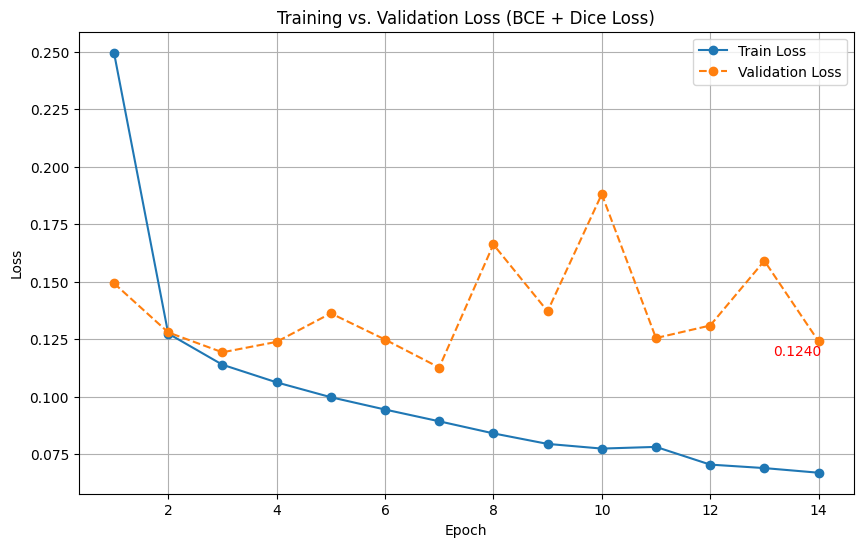

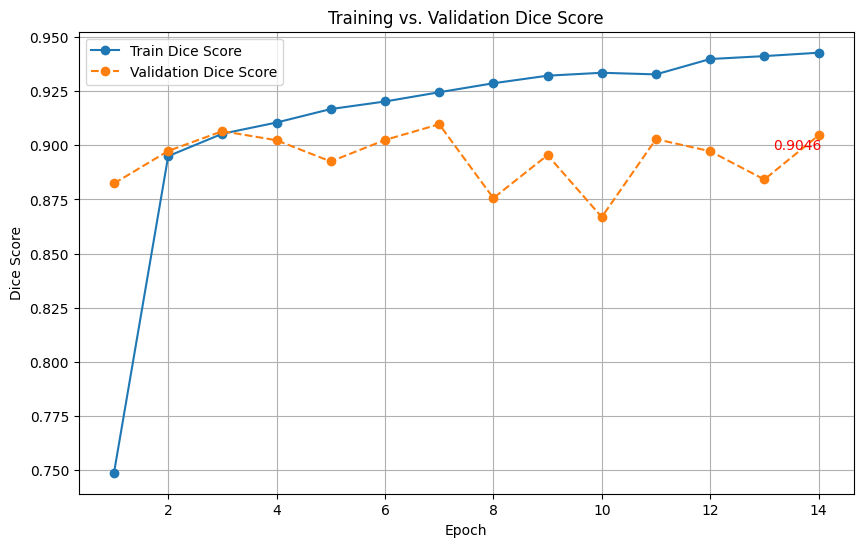

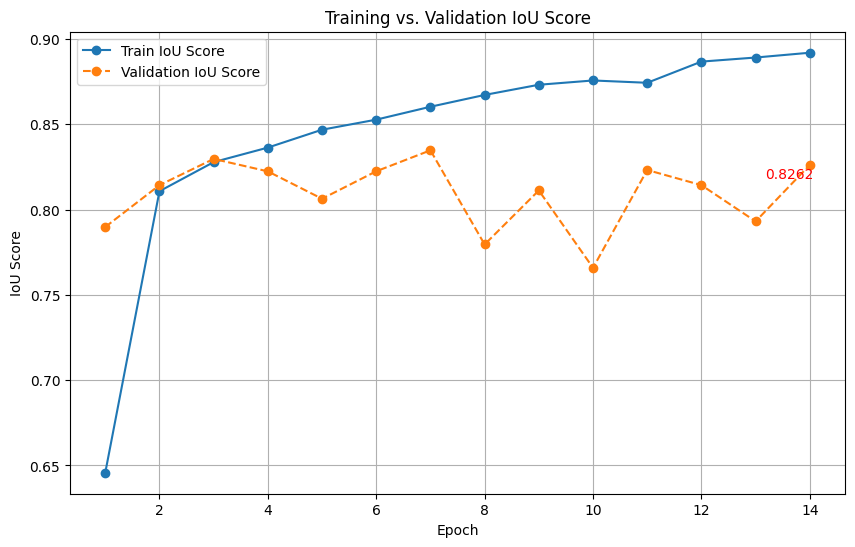

In [25]:
# Define the epoch range
epochs = range(1, len(train_losses) + 1)

# Plot Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', linestyle='-', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', linestyle='--', label='Validation Loss')
plt.title('Training vs. Validation Loss (BCE + Dice Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.annotate(f"{val_losses[-1]:.4f}", (epochs[-1], val_losses[-1]), textcoords="offset points", xytext=(-15,-10), ha='center', fontsize=10, color='red')
plt.show()

# Plot Training vs Validation Dice Score
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_dice_scores, marker='o', linestyle='-', label='Train Dice Score')
plt.plot(epochs, val_dice_scores, marker='o', linestyle='--', label='Validation Dice Score')
plt.title('Training vs. Validation Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.grid(True)
plt.annotate(f"{val_dice_scores[-1]:.4f}", (epochs[-1], val_dice_scores[-1]), textcoords="offset points", xytext=(-15,-10), ha='center', fontsize=10, color='red')
plt.show()

# Plot Training vs Validation IoU Score
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_iou_scores, marker='o', linestyle='-', label='Train IoU Score')
plt.plot(epochs, val_iou_scores, marker='o', linestyle='--', label='Validation IoU Score')
plt.title('Training vs. Validation IoU Score')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()
plt.grid(True)
plt.annotate(f"{val_iou_scores[-1]:.4f}", (epochs[-1], val_iou_scores[-1]), textcoords="offset points", xytext=(-15,-10), ha='center', fontsize=10, color='red')
plt.show()

## Step 12:  Pick Random Test Images for Visualization

In [26]:
# Define resize transform (matches what was done in training)
transform_resize = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224), interpolation=T.InterpolationMode.BILINEAR)
])

# 1. Specify the paths to your test images and masks
test_images_path = f"{BASE_DIR}/test_images.npy"
test_masks_path  = f"{BASE_DIR}/test_masks.npy"

# 2. Instantiate the test dataset
test_dataset = ISICDataset(
    images_path=test_images_path,
    masks_path=test_masks_path,
    transform=None  # Ensure same preprocessing as training
)
# Quick check
print(f"Test dataset size: {len(test_dataset)} samples")

Test dataset size: 1000 samples


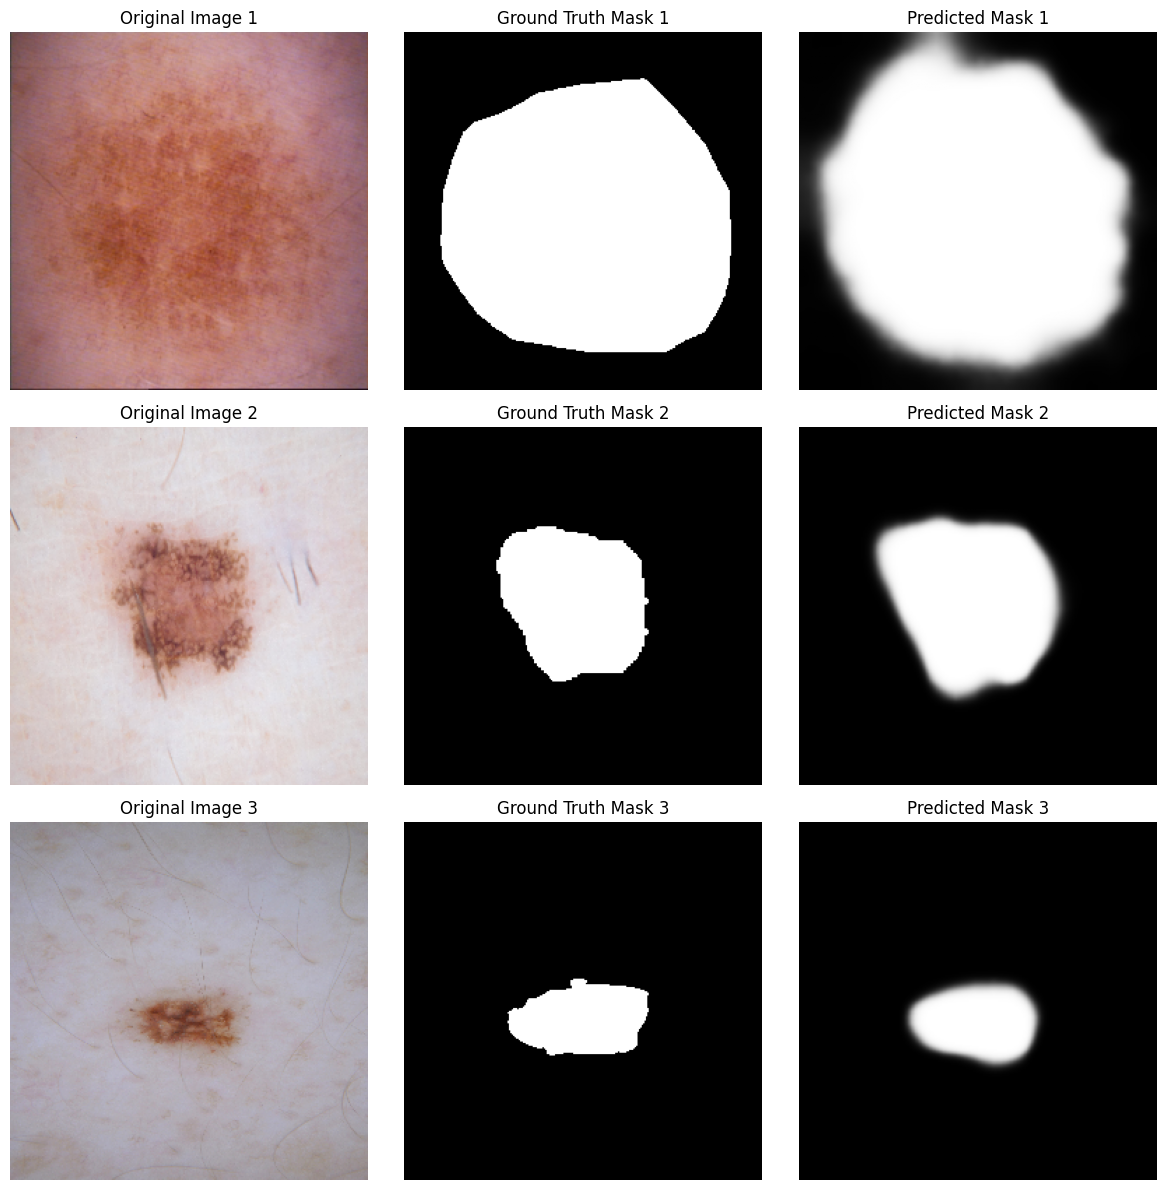

In [27]:
# Pick three random test samples
random_indices = random.sample(range(len(test_dataset)), 3)  # Select 3 random indices
selected_images = []
selected_masks = []
selected_preds = []

# Process each selected image
for idx in random_indices:
    image, mask = test_dataset[idx]  # Load image & mask from test dataset

    # Convert image to tensor and resize to 224x224
    image_tensor = transform_resize(image).unsqueeze(0).to(device)

    # Get model prediction
    with torch.no_grad():
        pred_mask = best_model(image_tensor)  # Forward pass
        pred_mask = torch.sigmoid(pred_mask)  # Apply sigmoid activation
        pred_mask = pred_mask.squeeze().cpu().numpy()  # Remove batch & move to CPU

    # Convert original image & mask to NumPy for visualization
    image_np = np.array(image)  # Convert PIL Image to NumPy
    mask_np = np.array(mask)  # Convert mask to NumPy

    # Store images for plotting
    selected_images.append(image_np)
    selected_masks.append(mask_np)
    selected_preds.append(pred_mask)

# 6. Plot images side by side
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i in range(3):
    axes[i, 0].imshow(selected_images[i])
    axes[i, 0].set_title(f"Original Image {i+1}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(selected_masks[i], cmap="gray")
    axes[i, 1].set_title(f"Ground Truth Mask {i+1}")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(selected_preds[i], cmap="gray")
    axes[i, 2].set_title(f"Predicted Mask {i+1}")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

## Step 13: Compute Evaluation Metrics

In [28]:
# Define metric functions explicitly for **binary segmentation**
dice_metric = torchmetrics.Dice(num_classes=1, threshold=0.5, average="micro", multiclass=False).to(device)
iou_metric = torchmetrics.JaccardIndex(task="binary").to(device)

# Convert NumPy arrays back to PyTorch tensors (ensure correct shape)
pred_mask_tensor = torch.tensor(pred_mask).unsqueeze(0).to(device)  # Shape → (1, 256, 256)
mask_tensor = torch.tensor(mask).unsqueeze(0).to(device)  # Shape → (1, 256, 256)

# Convert tensors to binary masks
pred_binary = (pred_mask_tensor > 0.5).int()  # Convert predictions to int
mask_binary = (mask_tensor > 0.5).int()  # Convert ground truth mask to int

# Compute Dice and IoU scores
dice_score = dice_metric(pred_binary, mask_binary).item()
iou_score = iou_metric(pred_binary, mask_binary).item()

# Display results
print(f"Dice Score: {dice_score:.4f}")
print(f"IoU Score: {iou_score:.4f}")

Dice Score: 0.9161
IoU Score: 0.8451


<ipython-input-28-80fb2641d4f2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_tensor = torch.tensor(mask).unsqueeze(0).to(device)  # Shape → (1, 256, 256)


## Step 14: Evaluating the Entire Test Set

In [29]:
# Run evaluation on the entire test set
best_model.eval()  # Ensure model is in evaluation mode

test_dice, test_iou = 0.0, 0.0
num_samples = 0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        preds = best_model(images)
        preds = torch.sigmoid(preds)  # Convert logits to probabilities
        pred_binary = (preds > 0.5).int()  # Binarize predictions

        # Compute Dice & IoU
        test_dice += dice_metric(pred_binary, masks.unsqueeze(1).int()).item()
        test_iou += iou_metric(pred_binary, masks.unsqueeze(1).int()).item()
        num_samples += 1

# Compute average metrics
test_dice /= num_samples
test_iou /= num_samples

print(f"Final Test Dice Score: {test_dice:.4f}")
print(f"Final Test IoU Score: {test_iou:.4f}")

Final Test Dice Score: 0.8917
Final Test IoU Score: 0.8069


## Step 15: Saving the Model In Google Drive

In [30]:
# Define the model save directory
MODEL_DIR = "/content/drive/MyDrive/swinunet-medical-segmentation/models"

# Ensure the directory exists
os.makedirs(MODEL_DIR, exist_ok=True)

# Define path to save the model
MODEL_PATH = os.path.join(MODEL_DIR, "best_swin_upernet.pth")

# Load the best model from training before saving
best_model = SwinUPerNet(num_classes=1).to(device)  # Ensure correct architecture
best_model.load_state_dict(torch.load("best_swin_upernet.pth", map_location=device, weights_only=True), strict=False)
best_model.eval()  # Set to evaluation mode

# Save the final best model
torch.save(best_model.state_dict(), MODEL_PATH)

print(f"Model successfully saved at: {MODEL_PATH}")

Model successfully saved at: /content/drive/MyDrive/swinunet-medical-segmentation/models/best_swin_upernet.pth
